In [1]:
import os
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
from utils import tools, metrics
from modules.aae_base_module import AAEBaseModule
from models import supported_models
from datasets import supported_datamodules

plt.style.use('seaborn')
log_path = Path('../logs/CuriosityDataModule/SimpleAAE/archive_v1_2021-04-21')

In [2]:
config = tools.load_config(log_path / 'configuration.yaml', silent=True)
model_type = log_path.parent.name
model_name = log_path.name
model_path = next(iter((log_path / 'checkpoints').glob('val_r_loss*')))

datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
    **config['data-parameters'])
datamodule.setup('test')

model = supported_models[config['experiment-parameters']['model']](
    in_nodes=reduce(lambda x, y: x*y, datamodule.data_shape),
    latent_nodes=config['module-parameters']['latent_nodes'])

module = AAEBaseModule(
        model,
        batch_size=datamodule.batch_size,
        **config['module-parameters'])

# Load the state_dict into the module architecture
checkpoint = torch.load(model_path)
module.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
test_novelty_scores = []
test_novelty_labels = []
latent_vecs = []
module.encoder.eval()  # Freeze dropout and batch normalization parameters
module.decoder.eval()
module.discriminator.eval()
with torch.no_grad():
    for batch_nb, batch in enumerate(datamodule.test_dataloader()):
        result = module.test_step(batch, batch_nb)

        l = result['images']['batch_lt']
        latent_vecs.extend(l.cpu().numpy())
        
        test_novelty_scores.extend(result['scores'].cpu().numpy())
        test_novelty_labels.extend(result['labels'].cpu().numpy())
        print(f'[BATCH {batch_nb}] Mean score: {result["scores"].mean()}')

[BATCH 0] Mean score: 0.8496554493904114
[BATCH 1] Mean score: 0.8472225666046143
[BATCH 2] Mean score: 0.8297674655914307
[BATCH 3] Mean score: 0.8703542947769165
[BATCH 4] Mean score: 0.9005417227745056
[BATCH 5] Mean score: 0.9090173244476318


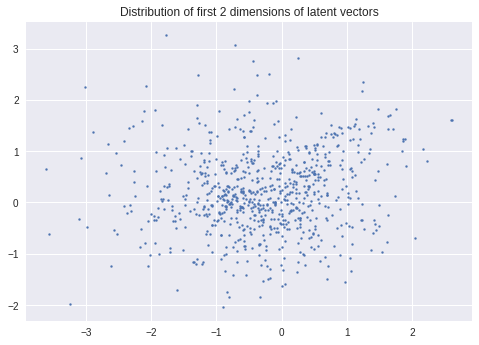

In [5]:
lt = np.stack(latent_vecs, axis=0)
plt.scatter(lt[:, 0], lt[:, 1], s=4)
plt.title('Distribution of first 2 dimensions of latent vectors')
plt.show()

In [7]:
# Code for setting up advanced plotting and graphing
x_mean = lt[:, 0].mean()
x_var = lt[:, 0].var()
y_mean = lt[:, 1].mean()
y_var = lt[:, 1].var()

x = np.linspace(-6., 6., 100)
y = np.linspace(-6., 6., 100)

def gaussian2d(x, y, x_mu, x_var, y_mu, y_var):
    arg_x = (x - x_mu)**2 / (2*x_var**2)
    arg_y = (y - y_mu)**2 / (2*y_var**2)    
    return np.exp(-(arg_x + arg_y))

X, Y = np.meshgrid(x, y)
Z = gaussian2d(X, Y, x_mean, x_var, y_mean, y_var)
print(Z.max())

def radius_from_mean(x_mean, y_mean, x_comp, y_comp):
    return np.sqrt( (x_mean - x_comp)**2 + (y_mean - y_comp)**2 )

0.9987882386533663


2021-04-22 10:45:13,976 - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x7fa9a8762700>
2021-04-22 10:45:13,976 - DEBUG - Using fixed locator on colorbar


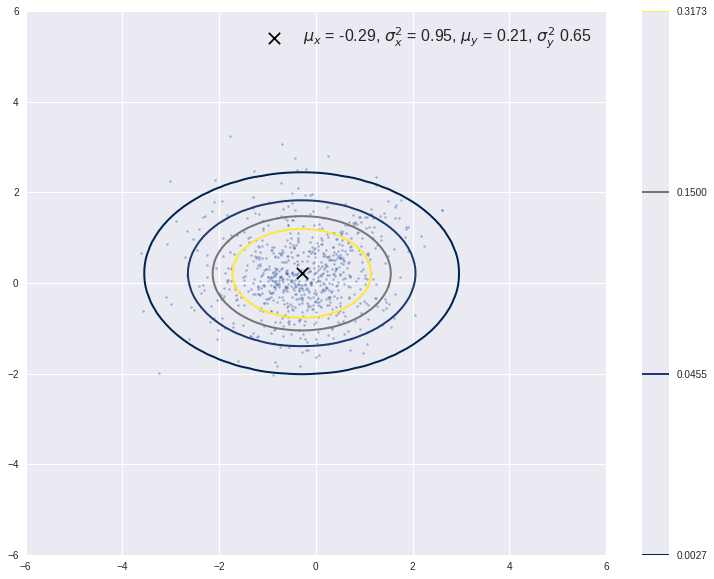

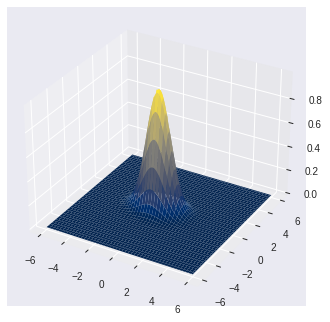

In [10]:
plt.figure(figsize=(13,10))
plt.scatter(lt[:, 0], lt[:, 1], s=4, alpha=0.5)

plt.contour(X, Y, Z, levels=[1-0.9973, 1-0.9545, 1-0.85, 1-0.6827], cmap='cividis', linewidths=2)
plt.colorbar()
plt.scatter([x_mean], [y_mean], color='k', marker='x', s=2**7, 
            label=r'$\mu_x$ = {:.2f}, $\sigma^2_x$ = {:.2f}, $\mu_y$ = {:.2f}, $\sigma^2_y$ {:.2f}'.format(x_mean, x_var, y_mean, y_var))
plt.legend(fontsize=16)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='cividis')
plt.show()

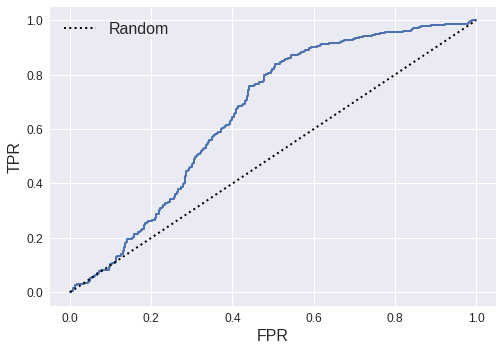

ROC AUC: 0.6582859731488346
Random ROC AUC: 0.5


In [11]:
fpr, tpr, threshold, auc = metrics.roc(test_novelty_scores, test_novelty_labels)

plt.plot(fpr, tpr, lw=2.)
    
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()

print(f'ROC AUC: {auc}')
print('Random ROC AUC: 0.5')

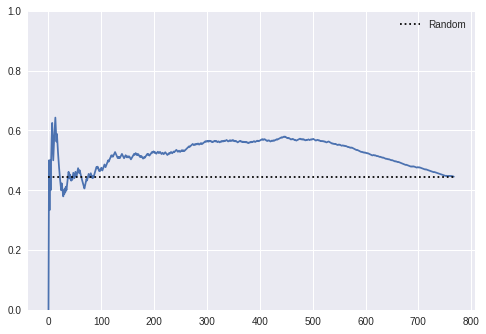

In [15]:
pak = metrics.precision_at_k(test_novelty_scores, test_novelty_labels)

uniques, counts = np.unique(test_novelty_labels, return_counts=True)
random = counts.min() / counts.sum()

plt.plot(pak)
plt.plot([0, len(pak)], [random, random], 'k:', label='Random')
plt.ylim([0., 1.])
plt.legend()
plt.show()